# AI Finance Project - Loda Enrico

In [1]:
!pip install yfinance pmdarima==2.0.4 arch==7.2.0 matplotlib==3.10.3 numpy==1.26.4

In [2]:
# import
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import scipy.stats as sps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmdarima as arima
from arch import arch_model

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1 - Data Collection and Preparation
We want to calculate the daily simple rate of return of our assets. To do so, we define:

**Simple rate of return**  

The formula is:
$$
r = \frac{\frac{C}{P}-1}{T}
$$

Given:  
- **P**: the price of the asset at the time of investment  
- **T**: maturity (number of periods)  
- **C**: the price of the asset at maturity **T**

---

**Daily simple rate of return:**  
For daily returns, considering $P_t$ as the close price of the asset at time t, the formula is:
$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

In [3]:
df = yf.download(["SPY","NVDA"], start="2010-01-01", end="2025-05-17")
spy = df.xs('SPY', axis=1, level=1)
nvda = df.xs('NVDA', axis=1, level=1)

prices = df["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.dropna()
SPY_r = returns['SPY']
NVDA_r = returns['NVDA']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [4]:
df

Price            Close                    High                     Low  \
Ticker            NVDA         SPY        NVDA         SPY        NVDA   
Date                                                                     
2010-01-04    0.423884   85.768402    0.426864   85.813808    0.415172   
2010-01-05    0.430073   85.995483    0.434658   86.033326    0.422279   
2010-01-06    0.432824   86.056030    0.433741   86.267934    0.425718   
2010-01-07    0.424342   86.419289    0.432366   86.525241    0.421133   
2010-01-08    0.425259   86.706902    0.428239   86.744744    0.418382   
...                ...         ...         ...         ...         ...   
2025-05-12  123.000000  582.989990  123.000000  583.000000  120.279999   
2025-05-13  129.929993  586.840027  131.220001  589.080017  124.470001   
2025-05-14  135.339996  587.590027  135.440002  588.979980  131.679993   
2025-05-15  134.830002  590.460022  136.300003  590.969971  132.660004   
2025-05-16  135.399994  594.200012  136.350006  594.500000  133.460007   

Price                         Open                 Volume             
Ticker             SPY        NVDA         SPY       NVDA        SPY  
Date                                                                  
2010-01-04   84.391022    0.424342   85.041873  800204000  118944600  
2010-01-05   85.405178    0.422279   85.715470  728648000  111579900  
2010-01-06   85.844126    0.429844   85.912236  649168000  116074400  
2010-01-07   85.654916    0.430532   85.897093  547792000  131091100  
2010-01-08   86.018214    0.420903   86.192275  478168000  126402800  
...                ...         ...         ...        ...        ...  
2025-05-12  577.039978  121.970001  581.469971  225023300   78993600  
2025-05-13  582.840027  124.980003  583.409973  330430100   67947200  
2025-05-14  585.539978  133.199997  587.809998  281180800   66283500  
2025-05-15  585.099976  134.289993  585.559998  226632600   71268100  
2025-05-16  589.280029  136.220001  591.250000  226542500   76052100  

[3867 rows x 10 columns]

In [5]:
returns[:]

Ticker,NVDA,SPY
Date,,
2010-01-05,0.014603,0.002648
2010-01-06,0.006397,0.000704
2010-01-07,-0.019597,0.004221
2010-01-08,0.002161,0.003328
2010-01-11,-0.014016,0.001396
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


In [6]:
dates = returns.index.strftime('%Y-%m-%d')
dates

Index(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-11',
       '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-19',
       ...
       '2025-05-05', '2025-05-06', '2025-05-07', '2025-05-08', '2025-05-09',
       '2025-05-12', '2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16'],
      dtype='object', name='Date', length=3866)

##dataset for training
The features, for a total of 24, are the following:

*   $\mu_1$, $\mu_2$ of $r_1$, $r_2$ calculated on the last 10 lags
*   $[r_1^t,\dots ,r_1^{t-10}]$, $[r_2^t,\dots ,r_2^{t-10}]$

The target is the values of my covariance matrix:
* $\Sigma_{t+1}$

In [7]:
rNVDA_series = returns['NVDA']
rSPY_series = returns['SPY']
df = pd.DataFrame()
df['rNVDA_today'] = rNVDA_series
df['rSPY_today'] = rSPY_series

for i in range(1, 11):
    df[f'rNVDA_t-{i}'] = rNVDA_series.shift(i)
    df[f'rSPY_t-{i}'] = rSPY_series.shift(i)

df.head(11)

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-6,rSPY_t-6,rNVDA_t-7,rSPY_t-7,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014603,0.002648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.006397,0.000704,0.014603,0.002648,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.019597,0.004221,0.006397,0.000704,0.014603,0.002648,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002161,0.003328,-0.019597,0.004221,0.006397,0.000704,0.014603,0.002648,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,-0.014016,0.001396,0.002161,0.003328,-0.019597,0.004221,0.006397,0.000704,0.014603,0.002648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.019597,0.004221,0.006397,0.000704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,0.013583,0.008446,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.019597,0.004221,...,0.014603,0.002648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,-0.015634,0.002705,0.013583,0.008446,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,...,0.006397,0.000704,0.014603,0.002648,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.029495,-0.011224,-0.015634,0.002705,0.013583,0.008446,-0.033898,-0.009326,-0.014016,0.001396,...,-0.019597,0.004221,0.006397,0.000704,0.014603,0.002648,NaN,NaN,NaN,NaN


In [8]:
rSPY_series

,SPY
Date,
2010-01-05,0.002648
2010-01-06,0.000704
2010-01-07,0.004221
2010-01-08,0.003328
2010-01-11,0.001396
...,...
2025-05-12,0.033047
2025-05-13,0.006604
2025-05-14,0.001278


In [9]:
cols = [f'rNVDA_t-{i}' for i in range(1, 11)]
df['mean_NVDA'] = df[cols].mean(axis=1)
cols.append('rNVDA_today')
df['var_NVDA'] = df[cols].var(axis=1)

cols = [f'rSPY_t-{i}' for i in range(1, 11)]
df['mean_SPY'] = df[cols].mean(axis=1)
cols.append('rSPY_today')
df['var_SPY'] = df[cols].var(axis=1)
df = df.dropna()
df#["r2_t-10"]

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,0.013583,0.008446,...,-0.019597,0.004221,0.006397,0.000704,0.014603,0.002648,-0.005720,0.000331,0.001539,0.000059
2010-01-21,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,...,0.002161,0.003328,-0.019597,0.004221,0.006397,0.000704,-0.007581,0.000296,0.000258,0.000093
2010-01-22,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,...,-0.014016,0.001396,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131
2010-01-25,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,...,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132
2010-01-26,-0.031660,-0.004190,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,...,0.013583,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010023,0.000424,-0.004207,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,-0.000917,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127
2025-05-13,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.024697,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124
2025-05-14,0.041638,0.001278,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,...,0.025894,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126


In [10]:
count = (df['var_SPY'] > df['var_NVDA']).sum()
print(f"The number of times 'var_SPY' is larger than 'var_NVDA' is: {count}")

The number of times 'var_SPY' is larger than 'var_NVDA' is: 23


In [11]:
def compute_covariance_row(row):
    r1 = [row[f'rNVDA_t-{i}'] for i in range(1, 11)]
    r1.append(row['rNVDA_today'])

    r2 = [row[f'rSPY_t-{i}'] for i in range(1, 11)]
    r2.append(row['rSPY_today'])

    return np.cov(r1, r2)[0, 1]

df['cov'] = df.apply(compute_covariance_row, axis=1)
df

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,0.013583,0.008446,...,0.004221,0.006397,0.000704,0.014603,0.002648,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,...,0.003328,-0.019597,0.004221,0.006397,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,...,0.001396,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,...,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,-0.031660,-0.004190,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,...,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010023,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127,0.000202
2025-05-13,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124,0.000190
2025-05-14,0.041638,0.001278,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,...,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126,0.000181


In [12]:
df_r = df.loc[:][['rNVDA_today', 'rSPY_today']]
df.drop(['rNVDA_today', 'rSPY_today'], axis=1, inplace=True)
df

,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,rNVDA_t-5,rSPY_t-5,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,0.013583,0.008446,-0.033898,-0.009326,...,0.004221,0.006397,0.000704,0.014603,0.002648,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,0.013583,0.008446,...,0.003328,-0.019597,0.004221,0.006397,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,-0.015634,0.002705,...,0.001396,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,-0.029495,-0.011224,...,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019228,-0.004016,-0.010169,0.018702,0.012496,...,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010023,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,-0.005939,-0.005734,...,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127,0.000202
2025-05-13,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124,0.000190
2025-05-14,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126,0.000181


In [13]:
df_r

,rNVDA_today,rSPY_today
Date,,
2010-01-20,-0.004016,-0.010169
2010-01-21,-0.017857,-0.019228
2010-01-22,-0.034604,-0.022292
2010-01-25,0.017011,0.005128
2010-01-26,-0.031660,-0.004190
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


### we are trying to scale in order to have numerical stability, we are not sure it is correct since we need to have the non-scaled version of the variance at inference time

In [14]:
train_df = df.loc["2010-01-01":"2022-12-31"]
validation_df = df.loc["2023-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":]
print((len(train_df) + len(validation_df) + len(test_df)) == len(df))


##CARE FOR SCALER
#scaler = StandardScaler()
#scaler.fit(train_df)
#train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
#test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

True


Flip the columns in order to have a temporal sequence from past to present

In [15]:
train_df = train_df[train_df.columns[::-1]]
validation_df = validation_df[validation_df.columns[::-1]]
test_df = test_df[test_df.columns[::-1]]

In [16]:
train_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.000097,0.000059,0.001539,0.000331,-0.005720,0.002648,0.014603,0.000704,0.006397,0.004221,...,-0.009326,-0.033898,0.008446,0.013583,0.002705,-0.015634,-0.011224,-0.029495,0.012496,0.018702
2010-01-21,0.000111,0.000093,0.000258,0.000296,-0.007581,0.000704,0.006397,0.004221,-0.019597,0.003328,...,0.008446,0.013583,0.002705,-0.015634,-0.011224,-0.029495,0.012496,0.018702,-0.010169,-0.004016
2010-01-22,0.000153,0.000131,-0.001736,0.000327,-0.010007,0.004221,-0.019597,0.003328,0.002161,0.001396,...,0.002705,-0.015634,-0.011224,-0.029495,0.012496,0.018702,-0.010169,-0.004016,-0.019228,-0.017857
2010-01-25,0.000184,0.000132,-0.004387,0.000395,-0.011507,0.003328,0.002161,0.001396,-0.014016,-0.009326,...,-0.011224,-0.029495,0.012496,0.018702,-0.010169,-0.004016,-0.019228,-0.017857,-0.022292,-0.034604
2010-01-26,0.000175,0.000127,-0.004207,0.000424,-0.010023,0.001396,-0.014016,-0.009326,-0.033898,0.008446,...,0.012496,0.018702,-0.010169,-0.004016,-0.019228,-0.017857,-0.022292,-0.034604,0.005128,0.017011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.000335,0.000156,-0.003457,0.000964,-0.010718,-0.007470,-0.009785,0.014417,0.031410,0.007570,...,-0.011806,-0.022475,-0.008480,-0.019130,0.001368,-0.010397,0.014953,0.025862,-0.014266,-0.070420
2022-12-27,0.000345,0.000154,-0.002135,0.001299,-0.010607,0.014417,0.031410,0.007570,0.030624,-0.006394,...,-0.008480,-0.019130,0.001368,-0.010397,0.014953,0.025862,-0.014266,-0.070420,0.005752,-0.008671
2022-12-28,0.000246,0.000129,-0.003971,0.001070,-0.020883,0.007570,0.030624,-0.006394,-0.022023,-0.024462,...,0.001368,-0.010397,0.014953,0.025862,-0.014266,-0.070420,0.005752,-0.008671,-0.003943,-0.071354


In [17]:
test_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.000084,0.000042,0.001121,0.000290,0.002503,-0.001647,0.011169,0.005625,0.024279,0.006081,...,0.002010,-0.003266,0.004223,0.009195,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000
2024-01-03,0.000096,0.000048,0.000726,0.000287,-0.001348,0.005625,0.024279,0.006081,-0.009446,-0.013857,...,0.004223,0.009195,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341
2024-01-04,0.000076,0.000045,-0.000653,0.000227,-0.005020,0.006081,-0.009446,-0.013857,-0.030098,0.009482,...,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436
2024-01-05,0.000087,0.000041,-0.001584,0.000285,-0.003173,-0.013857,-0.030098,0.009482,0.018270,0.002010,...,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019
2024-01-08,0.000128,0.000042,-0.000061,0.000542,0.002126,0.009482,0.018270,0.002010,-0.003266,0.004223,...,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019,0.001370,0.022897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.000202,0.000127,0.002482,0.000471,0.005092,0.000381,-0.020539,0.006299,0.002667,0.000397,...,-0.005734,-0.005939,-0.008358,-0.002460,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134
2025-05-13,0.000190,0.000124,0.005748,0.000545,0.012589,0.006299,0.002667,0.000397,-0.000917,0.007087,...,-0.008358,-0.002460,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134,0.033047,0.054436
2025-05-14,0.000181,0.000126,0.005779,0.000575,0.017957,0.000397,-0.000917,0.007087,0.024697,0.014844,...,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134,0.033047,0.054436,0.006604,0.056341


In [18]:
scaler_feature  = StandardScaler()
scaler_target = StandardScaler()

class LSTMdataset(Dataset):
    def __init__(self, dataframe, train):
        super().__init__()

        feature_dataframe = dataframe.drop(['cov', 'var_NVDA', 'var_SPY'], axis=1)
        target_dataframe = dataframe[['cov', 'var_NVDA', 'var_SPY']]

        if train:
          feature_dataframe = scaler_feature.fit_transform(feature_dataframe)
          target_dataframe = scaler_target.fit_transform(target_dataframe)
        else:
          feature_dataframe = scaler_feature.transform(feature_dataframe)
          target_dataframe = scaler_target.transform(target_dataframe)

        self.X = torch.tensor(feature_dataframe, dtype=torch.float32)
        self.y = torch.tensor(target_dataframe, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# pre normalization
col_names = ['cov', 'var_NVDA', 'var_SPY']
for name in col_names:
    print(f"{name}: min={train_df[name].min():.6f}, max={train_df[name].max():.6f}")

cov: min=-0.000185, max=0.007358
var_NVDA: min=0.000019, max=0.011850
var_SPY: min=0.000002, max=0.004897


In [20]:
# post normalization
train_dataset = LSTMdataset(train_df, train=True)
train_dataset[3]


# Get all targets from the dataset as a tensor
all_targets = train_dataset[:][1]  # shape: (num_samples, 3)

# Convert to numpy array
all_targets_np = all_targets.numpy()

# Print min and max for each column (cov, var_NVDA, var_SPY)
col_names = ['cov', 'var_NVDA', 'var_SPY']
for i, name in enumerate(col_names):
    print(f"{name}: min={all_targets_np[:, i].min():.6f}, max={all_targets_np[:, i].max():.6f}")

cov: min=-0.866746, max=16.036295
var_NVDA: min=-0.747650, max=10.675822
var_SPY: min=-0.411306, max=15.820749




---


# 2 - Markowitz Portfolio Construction

## Construct and train the model

In [21]:
# batch first lets us have the tensor in the shape (batch=32, sequence=10, feature=2)
class LSTM(torch.nn.Module):
    def __init__(self, input_size=2, hidden_size=20, num_layers=2, output_size=3, dropout=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm  = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
          )
        # hidden size + 2 since the fc will take in input the mean of each asset
        self.fc_1 = torch.nn.Linear (hidden_size+2, (hidden_size+2)//2)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc_2 = torch.nn.Linear ((hidden_size+2)//2, output_size)

    # x_lstm = (32, 10, 2) [N,L,H_in]
    # x_means = (32,2)
    def forward (self, x_lstm, x_means):

      output_lstm, _ = self.lstm(x_lstm)

      # now x_lstm = (32, 10, hidden_size)[N,L,Hout​]
      # here we take only the last hidden state
      last_hidden_state = output_lstm[:,-1,:]

      # now last_hidden_state should be (32,hidden_size)

      x_cat = torch.cat([last_hidden_state, x_means], dim=1)
      x_out = self.fc_1(x_cat)
      x_out = torch.relu(x_out)
      x_out = self.dropout(x_out)
      x_out = self.fc_2(x_out)
      return x_out

### We use train and validation to fix hyperparameters

In [22]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            #reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            optimizer.zero_grad()
            outputs = model(x_lstm, x_means)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")


def evaluate_model(model, data_loader, criterion_mse, criterion_mae, device):
    predictions = []
    model.eval()  # Set the model to evaluation mode
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            # reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            outputs = model(x_lstm, x_means)

            loss_mse = criterion_mse(outputs, y)
            loss_mae = criterion_mae(outputs, y)

            predictions.append(scaler_target.inverse_transform(outputs.cpu()))

            total_mse += loss_mse.item() * X.size(0)
            total_mae += loss_mae.item()
            num_samples += X.size(0)

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, predictions

In [23]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
#learning_rate = 1e-4
weight_decay=1e-4
epochs = 50

# Prepare datasets and dataloaders
#print(train_df[-1:])
train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Device setup: CUDA > MPS (Mac) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Model, loss, optimizer
model_val = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model_val.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model_val, train_loader, criterion, optimizer, epochs, device)


Using device: cpu
Epoch 1/50, Loss: 1.002478
Epoch 2/50, Loss: 0.970397
Epoch 3/50, Loss: 0.948012
Epoch 4/50, Loss: 0.831511
Epoch 5/50, Loss: 0.682739
Epoch 6/50, Loss: 0.562775
Epoch 7/50, Loss: 0.539903
Epoch 8/50, Loss: 0.412762
Epoch 9/50, Loss: 0.383959
Epoch 10/50, Loss: 0.390284
Epoch 11/50, Loss: 0.388291
Epoch 12/50, Loss: 0.410359
Epoch 13/50, Loss: 0.332712
Epoch 14/50, Loss: 0.314329
Epoch 15/50, Loss: 0.490387
Epoch 16/50, Loss: 0.331421
Epoch 17/50, Loss: 0.265933
Epoch 18/50, Loss: 0.273676
Epoch 19/50, Loss: 0.277134
Epoch 20/50, Loss: 0.309857
Epoch 21/50, Loss: 0.263310
Epoch 22/50, Loss: 0.286789
Epoch 23/50, Loss: 0.293978
Epoch 24/50, Loss: 0.418652
Epoch 25/50, Loss: 0.272974
Epoch 26/50, Loss: 0.291359
Epoch 27/50, Loss: 0.271933
Epoch 28/50, Loss: 0.243953
Epoch 29/50, Loss: 0.257115
Epoch 30/50, Loss: 0.258867
Epoch 31/50, Loss: 0.273853
Epoch 32/50, Loss: 0.347493
Epoch 33/50, Loss: 0.276021
Epoch 34/50, Loss: 0.271749
Epoch 35/50, Loss: 0.280859
Epoch 36/50

### Validation

In [24]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')

validation_dataset = LSTMdataset(validation_df, train=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

model_val.eval()

val_mse = 0.0
val_mae = 0.0
avg_val_mse, avg_val_mae, _ = evaluate_model(model_val, val_loader, mse, mae, device)

print(f"Validation MSE: {avg_val_mse:.6f}")
print(f"Validation MAE: {avg_val_mae:.6f}")

Validation MSE: 0.255942
Validation MAE: 0.632051


###now train on whole dataset

In [25]:
train_df = pd.concat([train_df, validation_df])

train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model, train_loader, criterion, optimizer, epochs, device)


Epoch 1/50, Loss: 1.003798
Epoch 2/50, Loss: 0.984038
Epoch 3/50, Loss: 0.928350
Epoch 4/50, Loss: 0.793044
Epoch 5/50, Loss: 0.715310
Epoch 6/50, Loss: 0.589027
Epoch 7/50, Loss: 0.529043
Epoch 8/50, Loss: 0.506913
Epoch 9/50, Loss: 0.424813
Epoch 10/50, Loss: 0.517252
Epoch 11/50, Loss: 0.599079
Epoch 12/50, Loss: 0.412184
Epoch 13/50, Loss: 0.430510
Epoch 14/50, Loss: 0.384925
Epoch 15/50, Loss: 0.423445
Epoch 16/50, Loss: 0.379451
Epoch 17/50, Loss: 0.420660
Epoch 18/50, Loss: 0.292981
Epoch 19/50, Loss: 0.358427
Epoch 20/50, Loss: 0.319740
Epoch 21/50, Loss: 0.288517
Epoch 22/50, Loss: 0.256324
Epoch 23/50, Loss: 0.273721
Epoch 24/50, Loss: 0.324978
Epoch 25/50, Loss: 0.507358
Epoch 26/50, Loss: 0.352090
Epoch 27/50, Loss: 0.281553
Epoch 28/50, Loss: 0.330767
Epoch 29/50, Loss: 0.267593
Epoch 30/50, Loss: 0.260279
Epoch 31/50, Loss: 0.242527
Epoch 32/50, Loss: 0.231694
Epoch 33/50, Loss: 0.271008
Epoch 34/50, Loss: 0.237129
Epoch 35/50, Loss: 0.229017
Epoch 36/50, Loss: 0.262833
E

In [26]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')
#drop the last year, from
#test_df = test_df.loc[:"2024-12-31"]
#print last element
print(test_df[-1:])
test_dataset = LSTMdataset(test_df, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#save cov and variances of the train for the VaR and ES of third point
_, _, train_predictions = evaluate_model(model, train_loader, mse, mae, device)

model.eval()
test_mse = 0.0
test_mae = 0.0

avg_test_mse, avg_test_mae, predictions = evaluate_model(model, test_loader, mse, mae, device)

print(f"Test MSE: {avg_test_mse:.6f}")
print(f"Test MAE: {avg_test_mae:.6f}")

                cov   var_SPY  mean_SPY  var_NVDA  mean_NVDA  rSPY_t-10  \
Date                                                                      
2025-05-16  0.00017  0.000123  0.005646  0.000606   0.019366   0.014844   

            rNVDA_t-10  rSPY_t-9  rNVDA_t-9  rSPY_t-8  ...  rSPY_t-5  \
Date                                                   ...             
2025-05-16    0.025894 -0.005734  -0.005939 -0.008358  ... -0.001274   

            rNVDA_t-5  rSPY_t-4  rNVDA_t-4  rSPY_t-3  rNVDA_t-3  rSPY_t-2  \
Date                                                                        
2025-05-16  -0.006134  0.033047   0.054436  0.006604   0.056341  0.001278   

            rNVDA_t-2  rSPY_t-1  rNVDA_t-1  
Date                                        
2025-05-16   0.041638  0.004884  -0.003768  

[1 rows x 25 columns]
Test MSE: 0.349638
Test MAE: 0.901255


Create a list of output not considering the batch, then create a dataframe only with the returns

In [27]:
test_output = []
for pred in predictions:
    for val in pred:
        test_output.append(val)

train_output = []
for pred in train_predictions:
    for val in pred:
        train_output.append(val)


test_df_r = df_r.loc["2024-01-01":]
train_df_r = df_r.loc["2010-01-01":"2023-12-31"]

In [28]:
test_df_r

,rNVDA_today,rSPY_today
Date,,
2024-01-02,-0.027341,-0.005596
2024-01-03,-0.012436,-0.008167
2024-01-04,0.009019,-0.003221
2024-01-05,0.022897,0.001370
2024-01-08,0.064281,0.014276
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


## Create portfolio

In [29]:
def get_mvp(var1,var2,cov):
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    corr = cov/(std1*std2)
    #print("corr: ",corr)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(return1, return2, w):
    return w * return1 + (1-w)*return2

In [30]:
def run_portfolio_simulation(var_source='real', r1=None, r2=None, dataframe=None, capital=1000, output=None):
    weights_nvda, weights_spy = [], []
    capital_NVDA, capital_SPY = [], []
    returns_portfolio = []
    returns_portfolio.append(0)
    portfolio_values = [capital]
    nvda_asset_1 = True

    for day in range(len(dataframe)):
        #print(f"DAY {day}")
        row = dataframe.iloc[day]

        # Update portfolio value
        if day > 0:
            w_old = weights_nvda[day - 1] if nvda_asset_1 else weights_spy[day - 1]
            r_nvda = r1[day - 1]
            r_spy = r2[day - 1]
            daily_return = get_return_values(r_nvda, r_spy, w_old)
            returns_portfolio.append(daily_return)
            new_val = portfolio_values[day - 1] * (1 + daily_return)
            portfolio_values.append(new_val)
            #print("UPDATED PORTFOLIO VALUE:", new_val)

        # Retrieve variance & covariance
        if var_source == 'real':
            var_nvda = row['var_NVDA']
            var_spy = row['var_SPY']
            cov = row['cov']
        elif var_source == 'predicted':
            var_nvda = output[day][1]
            var_spy = output[day][2]
            cov = output[day][0]
        else:
            raise ValueError("var_source must be 'real' or 'predicted'")

        nvda_asset_1 = var_nvda >= var_spy

        # Allocation
        if nvda_asset_1:
            w = get_mvp(var_nvda, var_spy, cov)
            w_nvda, w_spy = w, 1 - w
        else:
            w = get_mvp(var_spy, var_nvda, cov)
            w_nvda, w_spy = 1 - w, w

        weights_nvda.append(w_nvda)
        weights_spy.append(w_spy)

        v_nvda, v_spy = get_capital_values(portfolio_values[day], w_nvda)
        capital_NVDA.append(v_nvda)
        capital_SPY.append(v_spy)

        # Print
        if day == 0:
            #print("NVDA ALLOCATED:", v_nvda)
            #print("SPY ALLOCATED:", v_spy)
            print("INITIAL PORTFOLIO VALUE:", portfolio_values[day])
        else:
            nvda_diff = v_nvda - capital_NVDA[day - 1]
            spy_diff = v_spy - capital_SPY[day - 1]

            #print(f"{'BUY' if nvda_diff > 0 else 'SELL'} NVDA: {abs(nvda_diff)}")
            #print(f"ACTUAL NVDA: {v_nvda}")

            #print(f"{'BUY' if spy_diff > 0 else 'SELL'} SPY: {abs(spy_diff)}")
            #print(f"ACTUAL SPY: {v_spy}")

    #print("FINAL PORTFOLIO VALUE:", portfolio_values[-1])
    return portfolio_values, weights_nvda, weights_spy, capital_NVDA, capital_SPY, returns_portfolio



In [31]:
# remember that returns_portfolio contains the actual numerical ratio, no scaling needed
oracle_result, weights_nvda_oracle, weights_spy_oracle, capital_NVDA_oracle, capital_SPY_oracle, _ = run_portfolio_simulation(var_source='real', r1=test_df_r['rNVDA_today'], r2=test_df_r['rSPY_today'], dataframe=test_df, capital=1000)
predicted_result, weights_nvda_pred, weights_spy_pred, capital_NVDA_pred, capital_SPY_pred, returns_portfolio = run_portfolio_simulation(var_source='predicted', r1=test_df_r['rNVDA_today'], r2=test_df_r['rSPY_today'], dataframe=test_df, capital=1000, output=test_output)

INITIAL PORTFOLIO VALUE: 1000
INITIAL PORTFOLIO VALUE: 1000


In [32]:
len(returns_portfolio)
print(returns_portfolio)

[0, -0.0037433059582794425, -0.007798743588049243, -0.004309151953952071, -0.000583965487074263, 0.009957109225916777, -0.003157472909319907, 0.004044282737567634, -0.0013156580197925911, 0.0009537953762729806, -0.006968331799581959, -0.005536811254252124, 0.008214990295540176, 0.010773319395417648, 0.002083281958125795, 0.002874200128728829, -0.0008083047903951982, 0.0055364079840694285, -0.0005773371375837141, 0.006616940309175855, -0.001241739195758583, -0.016027286320021514, 0.012125921351612782, 0.007230645022350023, -0.008073578307417884, 0.004269375724744386, 0.00672942847711367, 0.0010379763167552456, 0.003026722659118241, -0.0005765235657845918, -0.014694999434014424, 0.007897275432846504, 0.008334971569787155, -0.005320681247479279, -0.002212391287280841, 0.003464488330939957, 0.008218464899223536, 0.0002726047530559085, -0.00481057867681276, 0.003085074246707648, 0.0008789025315195005, 0.0006107763225032549, 0.0032539098866770696, -0.007079837400532193, -0.012699621779413413

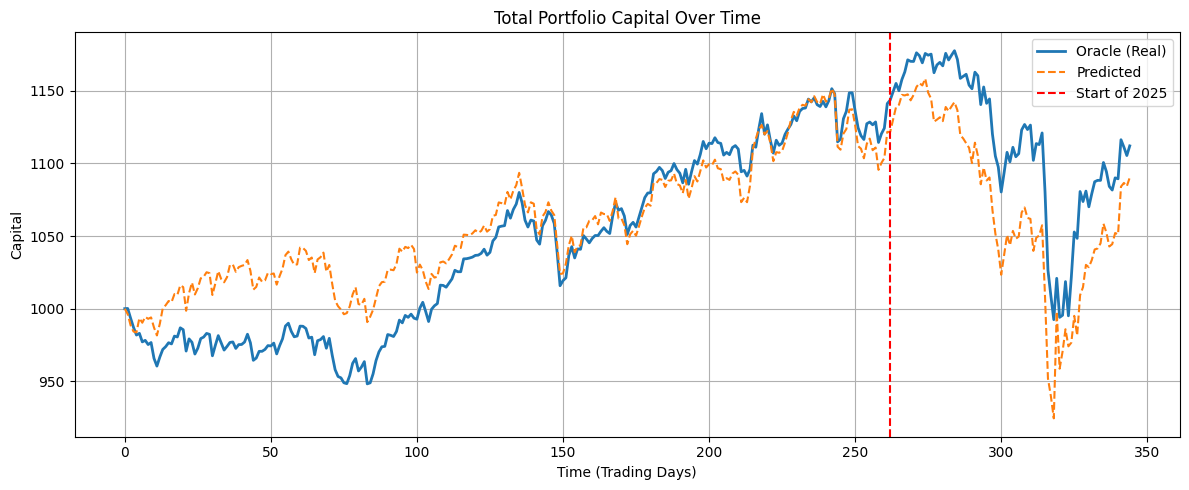

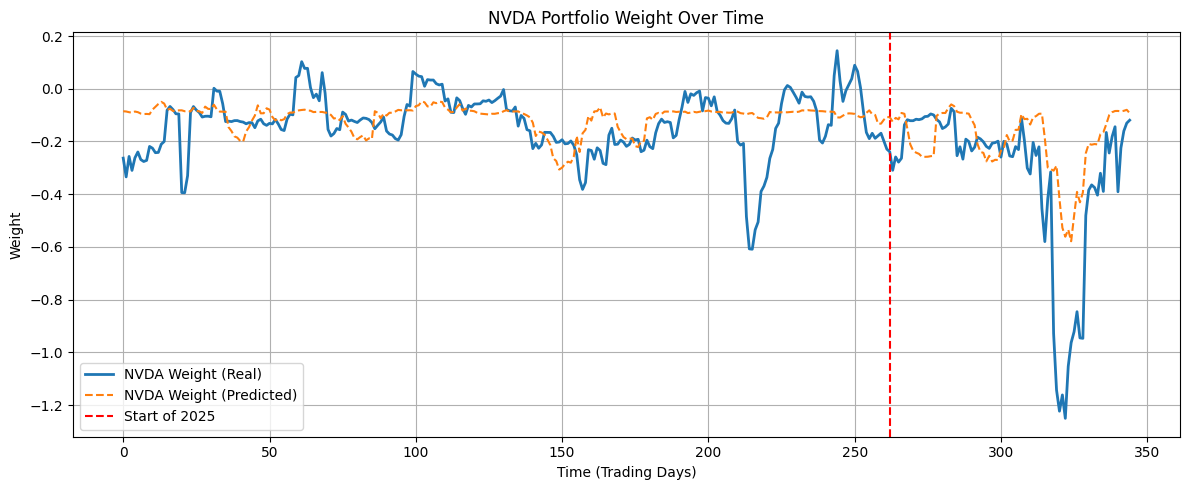

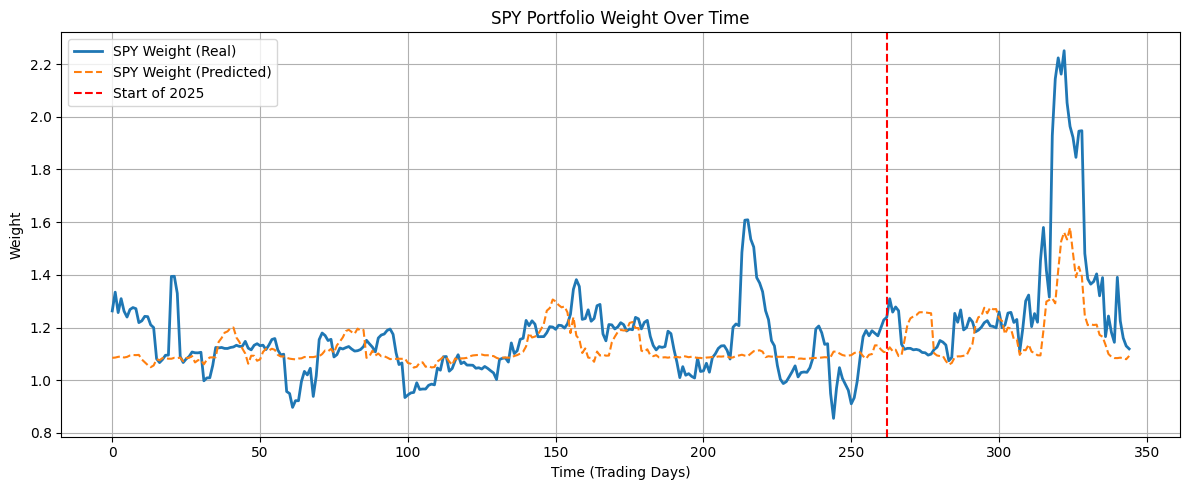

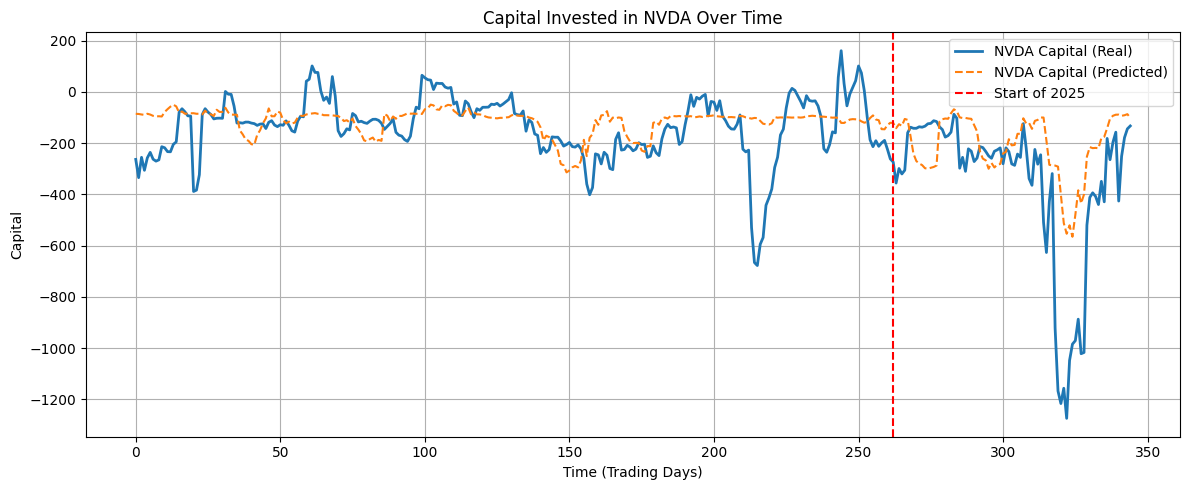

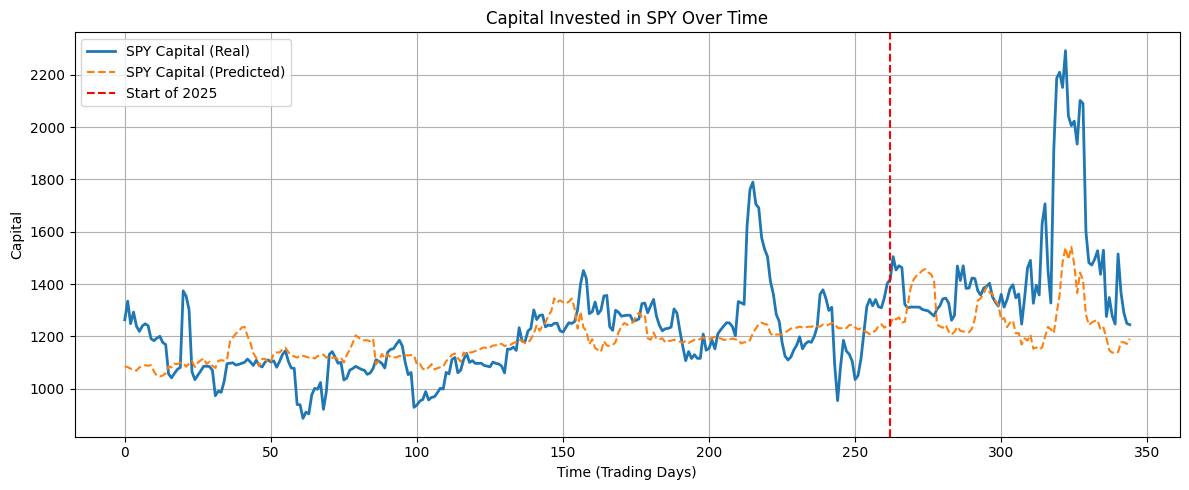

In [33]:
trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

time = list(range(len(oracle_result)))

# --- Total portfolio capital over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, oracle_result, label='Oracle (Real)', linewidth=2)
plt.plot(time, predicted_result, label='Predicted', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Total Portfolio Capital Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- NVDA weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, weights_nvda_oracle, label='NVDA Weight (Real)', linewidth=2)
plt.plot(time, weights_nvda_pred, label='NVDA Weight (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('NVDA Portfolio Weight Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SPY weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, weights_spy_oracle, label='SPY Weight (Real)', linewidth=2)
plt.plot(time, weights_spy_pred, label='SPY Weight (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('SPY Portfolio Weight Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Capital invested in NVDA over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, capital_NVDA_oracle, label='NVDA Capital (Real)', linewidth=2)
plt.plot(time, capital_NVDA_pred, label='NVDA Capital (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in NVDA Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Capital invested in SPY over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, capital_SPY_oracle, label='SPY Capital (Real)', linewidth=2)
plt.plot(time, capital_SPY_pred, label='SPY Capital (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in SPY Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




---


# 3 - Stress Testing Framework


## Standard case on train dataset

In [34]:
def get_VaR(alpha, mean, std):
  # norm.ppf(q, loc, scale) gives you the value x such that P(X ≤ x) = q for a normal distribution with mean loc and standard deviation scale.
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
  #This function approximates ES by averaging 40 quantiles beyond the VaR threshold.
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

In [35]:
# save weights assigned in the simulation of the train
_, weights_nvda_pred_train, weights_spy_pred_train, _, _, returns_portfolio_train = run_portfolio_simulation(var_source='predicted', r1=train_df_r['rNVDA_today'], r2=train_df_r['rSPY_today'], dataframe=train_df, capital=1000, output=train_output)

INITIAL PORTFOLIO VALUE: 1000


In [36]:
# we have outputs already, create temporal matrix for the w to use the formula of variance of a portfolio
# columns of output are  ['cov', 'var_NVDA', 'var_SPY']
sigma_matrices = []
for pred in train_output:
    cov = pred[0]
    var_nvda = pred[1]
    var_spy = pred[2]
    sigma = np.array([[var_nvda, cov],
                      [cov, var_spy]])
    sigma_matrices.append(sigma)
print(sigma_matrices[1])

# now we create a temporal matrix, each day having w_0 of weights_nvda_pred_train and w_1 of weights_spy_pred_train
matrix_weights_train = np.array([weights_nvda_pred_train, weights_spy_pred_train]).T
print("----------")
print(weights_nvda_pred_train[0])
print(matrix_weights_train[0])

# now we create a matrix of the variance of the portfolio using the formula wT SIGMA w
variance_portfolio_pred_train = []
for i in range(len(matrix_weights_train)):
    variance_portfolio_pred_train.append(np.dot(matrix_weights_train[i].T, np.dot(sigma_matrices[i], matrix_weights_train[i])))

[[5.14545333e-04 9.31164262e-05]
 [9.31164262e-05 5.86241135e-05]]
----------
-0.08451636898407902
[-0.08451637  1.08451637]


In [37]:
print(matrix_weights_train[45])

[-0.08547816  1.08547816]


In [38]:
VaRs_P = []
ESs_P = []
alpha = 0.95
mu = 0
for var in (variance_portfolio_pred_train):
    std = np.sqrt(var)
    VaRs_P.append(get_VaR(alpha, mu, std))
    ESs_P.append(get_ES(alpha, mu, std))

VaRs_P = np.array(VaRs_P)
ESs_P = np.array(ESs_P)

print("Means VaRs:",VaRs_P.mean(), "Means ESs:",ESs_P.mean())
print("Max VaRs:",VaRs_P.max(), "Max ESs:",ESs_P.max())
print("Min VaRs:",VaRs_P.min(), "Min ESs:",ESs_P.min())

Means VaRs: -0.014762737702756634 Means ESs: -0.01835502342461167
Max VaRs: -0.011464308763094047 Max ESs: -0.01425397240880864
Min VaRs: -0.0858823234314889 Min ESs: -0.10678046918429634


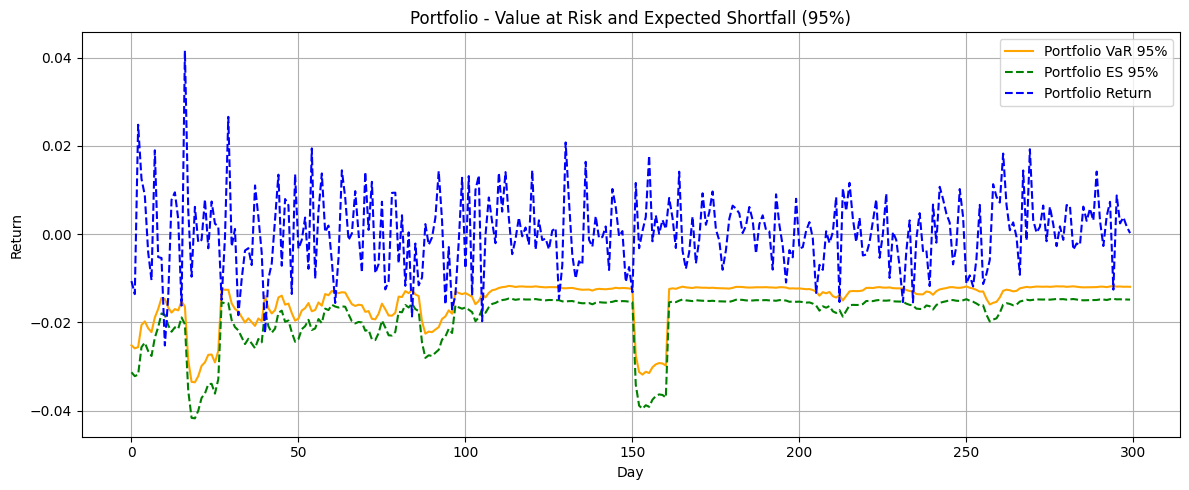

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(VaRs_P[-301:-1], label='Portfolio VaR 95%', color='orange')
plt.plot(ESs_P[-301:-1], label='Portfolio ES 95%', color='green', linestyle='--')
plt.plot(returns_portfolio_train[-300:], label='Portfolio Return', color='blue', linestyle="--")
plt.title('Portfolio - Value at Risk and Expected Shortfall (95%)')
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Dynamic scenario generation model

We define some dataset for arma and garch

In [41]:
# train_df_r
spy_r_log = (np.log1p(train_df_r['rSPY_today']))
spy_r_squared = (np.log1p(train_df_r['rSPY_today']))**2

nvda_r_log = (np.log1p(train_df_r['rNVDA_today']))
nvda_r_squared = (np.log1p(train_df_r['rNVDA_today']))**2

spy_test_r_log = (np.log1p(test_df_r['rSPY_today']))
spy_test_r_squared = (np.log1p(test_df_r['rSPY_today']))**2

nvda_test_r_log = (np.log1p(test_df_r['rNVDA_today']))
nvda_test_r_squared = (np.log1p(test_df_r['rNVDA_today']))**2

trading_days_2024 = dates[(dates >= '2024-01-01') & (dates <= '2024-12-31')]
start_2025_index = len(trading_days_2024)

train_length = len(spy_r_log)
test_length = len(spy_test_r_log)

assert len(spy_r_log) == len(spy_r_squared) == len(nvda_r_log) == len(nvda_r_squared), "Train sets do not have the same length"
assert len(spy_test_r_log) == len(spy_test_r_squared) == len(nvda_test_r_log) == len(nvda_test_r_squared), "Test sets do not have the same length"

In [42]:
# Convert to pandas Series for indexes
portfolio_returns_train = pd.Series(returns_portfolio_train)
portfolio_returns_test = pd.Series(returns_portfolio)

portfolio_r_log = (np.log1p(portfolio_returns_train))
portfolio_r_squared = (np.log1p(portfolio_returns_train))**2

portfolio_test_r_log = (np.log1p(portfolio_returns_test))
portfolio_test_r_squared = (np.log1p(portfolio_returns_test))**2

### ARMA

$$Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$
$$ \epsilon_t \sim N(0, \sigma^2)$$

In [43]:
def get_ARMA(returns):
    arma_model = arima.AutoARIMA(d=0,information_criterion="bic",suppress_warnings=True,trace=True)
    arma_model.fit(y=returns)
    return arma_model

def get_ARMA_predictions(arma_model,test_returns):
    arma_model.update(test_returns)
    prediction = arma_model.predict_in_sample()
    return prediction

def compute_VaR_ES(mean,variance,asset):

    variance = np.array(variance)

    train_VaR = get_VaR(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_VaR = get_VaR(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" mean VaR:")
    print(np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test "+asset+" mean VaR:")
    print(np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())

    train_ES = get_ES(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_ES = get_ES(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" mean ES:")
    print(np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test "+asset+" mean ES:")
    print(np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

def compute_backtest_results(train_returns, test_returns, train_VaR, test_VaR):
    print(f"Train VaR coverage: {(np.where((train_returns <= train_VaR), 1, 0)).mean():.6f}")
    print(f"Test VaR coverage: {(np.where((test_returns <= test_VaR), 1, 0)).mean():.6f}")

    test_returns_2024 = test_returns.iloc[:start_2025_index]
    test_VaR_2024 = test_VaR[:start_2025_index]

    test_returns_2025 = test_returns.iloc[start_2025_index:]
    test_VaR_2025 = test_VaR[start_2025_index:]

    print(f"Test VaR coverage (2024): {(np.where((test_returns_2024 <= test_VaR_2024), 1, 0)).mean():.6f}")
    print(f"Test VaR coverage (2025): {(np.where((test_returns_2025 <= test_VaR_2025), 1, 0)).mean():.6f}")


def plot_train_VaR_ES(train_returns, train_VaR, train_ES):
    tail = test_length
    n = train_length
    date_range = dates.values[n-tail:n]
    plt.figure(figsize=(14, 6))
    plt.plot(date_range, train_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, train_VaR[-tail:], label='VaR95')
    plt.plot(date_range, train_ES[-tail:], label='ES95')
    plt.title(f"VaR and ES (Last {tail} Train Data)")
    plt.xlabel("Date")
    plt.ylabel('Log Returns')
    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_test_VaR_ES(test_returns, test_VaR, test_ES):
    tail = test_length
    date_range = dates[-tail:]

    plt.figure(figsize=(14, 6))
    plt.plot(date_range, test_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, test_VaR[-tail:], label='VaR95')
    plt.plot(date_range, test_ES[-tail:], label='ES95')
    plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
    plt.title(f"VaR and ES (Test Data)")
    plt.xlabel("Date")
    plt.ylabel('Log Return')
    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [44]:
portfolio_arma = get_ARMA(portfolio_r_squared)
print(portfolio_arma.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-47612.679, Time=3.97 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-46533.432, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-47057.246, Time=1.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-46829.002, Time=1.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-46196.397, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-47569.705, Time=8.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-36207.764, Time=5.72 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : BIC=-47620.737, Time=5.86 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : BIC=-47548.939, Time=4.16 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : BIC=-46482.698, Time=6.73 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : BIC=-47649.689, Time=4.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : BIC=-47625.009, Time=4.48 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : BIC=-46474.501, Time=10.26 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : BIC=-47626.198, Time=3.83 sec
 ARI

In [45]:
arma_portfolio_variance = get_ARMA_predictions(portfolio_arma, portfolio_test_r_squared)

print(arma_portfolio_variance[arma_portfolio_variance < 0].shape)
#clip the small amount of negative variances to a very small number, we take e-10 since it is the smallest variance that we get
arma_portfolio_variance = np.maximum(arma_portfolio_variance, 1e-10)
print(arma_portfolio_variance[arma_portfolio_variance < 0].shape)

zero_mean = np.zeros(train_length + test_length)

arma_train_portfolio_VaR, arma_test_portfolio_VaR, arma_train_portfolio_ES, arma_test_portfolio_ES = compute_VaR_ES(zero_mean, arma_portfolio_variance, "Portfolio")

(0,)
(0,)
Train Portfolio mean VaR:
-0.014167229278916683
Test Portfolio mean VaR:
-0.01349748272665336
Train Portfolio mean ES:
-0.01761460716245084
Test Portfolio mean ES:
-0.01678188806231735


In [46]:
compute_backtest_results(portfolio_r_log, portfolio_test_r_log, arma_train_portfolio_VaR, arma_test_portfolio_VaR)

Train VaR coverage: 0.064084
Test VaR coverage: 0.072464
Test VaR coverage (2024): 0.063492
Test VaR coverage (2025): 0.096774


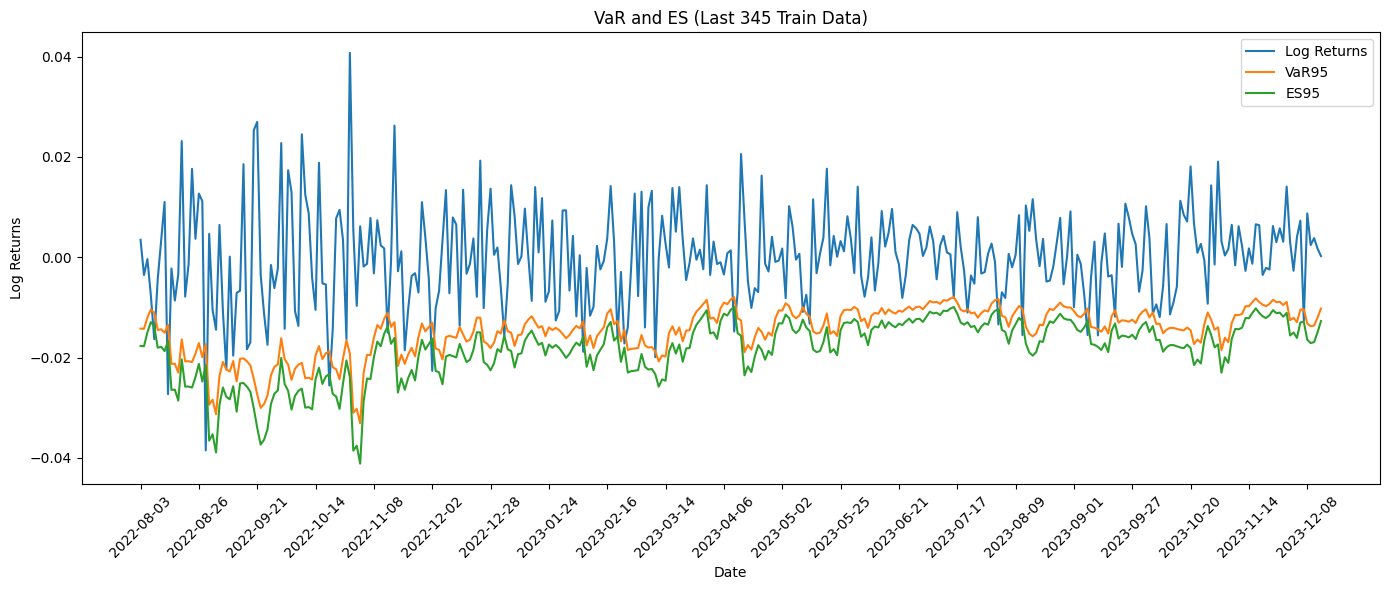

In [47]:
plot_train_VaR_ES(portfolio_r_log, arma_train_portfolio_VaR, arma_train_portfolio_ES)

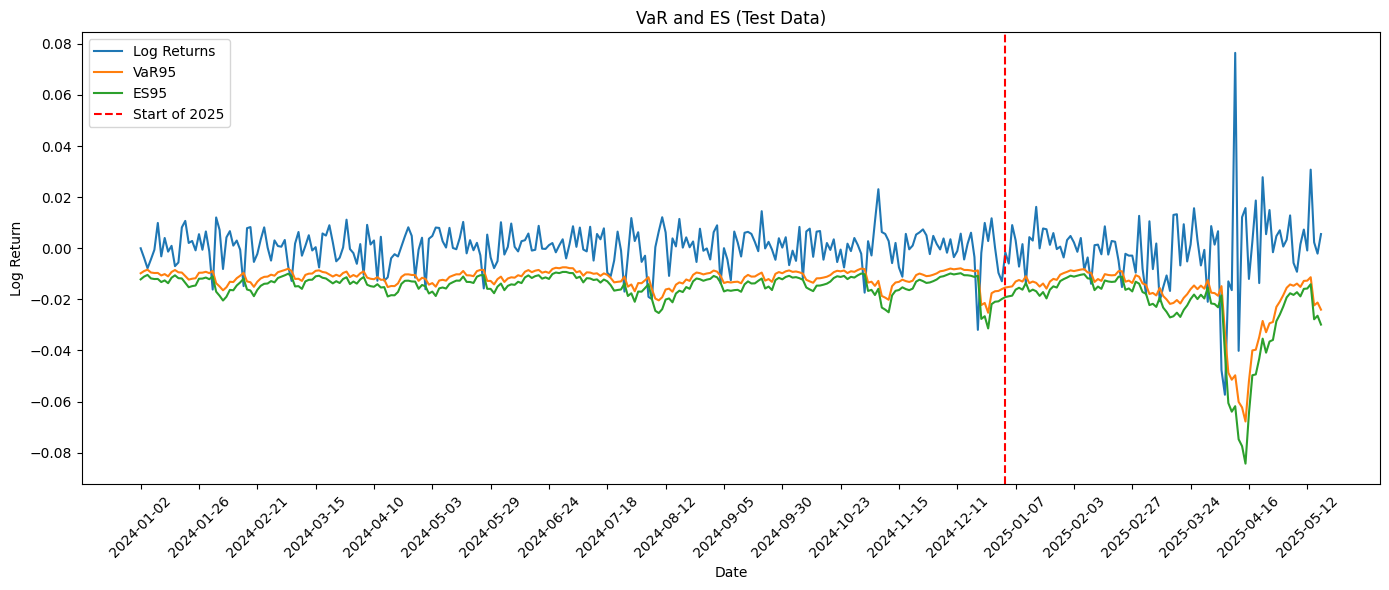

In [48]:
plot_test_VaR_ES(portfolio_test_r_log, arma_test_portfolio_VaR, arma_test_portfolio_ES)

### GARCH
The $GARCH(p, q)$ model is used to model the volatility of a financial asset over time. It captures the time-varying nature of volatility by allowing past squared returns and past volatility to influence current volatility.
It can be used in conjunction with $AR(r)$ model to capture both the mean and volatility dynamics of asset returns. This model is defined as follows:
$$
Y_t = \mu + \sum_{i=1}^{r} \phi_i Y_{t-i} + \epsilon_t \\
\text{where } \epsilon_t \sim \mathcal{N}(0, \sigma_t^2) \\
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
$$
where:
- $\sigma_t^2$ is the conditional variance (volatility) at time $t$,
- $\omega$ is a constant term,
- $\alpha_i$ are the coefficients for past squared returns (ARCH terms),
- $\beta_j$ are the coefficients for past volatility (GARCH terms),
- $p$ is the order of the GARCH part,
- $q$ is the order of the ARCH part,
- $r$ is the order of the autoregressive part,
- $s$ is the order of the moving average part.

In [118]:
def get_GARCH(train_returns,test_returns,arma_p,rescale):
    distributions = ['t','skewt','normal']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 4):
            for q in range(1, 4):
                model = arch_model(pd.concat([train_returns,test_returns]), vol='GARCH', p=p, q=q, mean="Zero", lags=arma_p, dist=dist, rescale=rescale)
                res = model.fit(disp='off',update_freq=0, cov_type="robust",last_obs=train_length)

                if res.bic < best_metric:
                    best_metric = res.bic
                    best_model = res
                    best_config = (p, q, dist)
                print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")

    print("Best config:", best_config)
    print("Best BIC:", best_metric)

    return best_model


def get_GARCH_prediction(garch_result):

    resid = garch_result.std_resid * garch_result.conditional_volatility
    train_mean = garch_result.model.y - resid

    train_variance = garch_result.conditional_volatility ** 2

    test_mean = garch_result.forecast(horizon=1,start=train_length).mean.values.flatten()
    test_variance = garch_result.forecast(horizon=1,start=train_length).variance.values.flatten()
    mean = np.concatenate([train_mean[:train_length], test_mean])
    variance = np.concatenate([train_variance[:train_length], test_variance])

    return mean, variance



In [98]:
scaler_portfolio_r_log = StandardScaler()
portfolio_r_log_s = scaler_portfolio_r_log.fit_transform(portfolio_r_log.values.reshape(-1, 1)).flatten()
portfolio_test_r_log_s = scaler_portfolio_r_log.transform(portfolio_test_r_log.values.reshape(-1, 1)).flatten()

portfolio_r_log_s = pd.Series(portfolio_r_log_s, index=portfolio_r_log.index)
portfolio_test_r_log_s = pd.Series(portfolio_test_r_log_s, index=portfolio_test_r_log.index)

In [119]:
garch_portfolio = get_GARCH(portfolio_r_log_s, portfolio_test_r_log_s, arma_p=3, rescale=False)
print("GARCH model summary:")
print(garch_portfolio.summary())

Try: p=1, q=1, dist=t, BIC=8546.79
Try: p=1, q=2, dist=t, BIC=8554.96
Try: p=1, q=3, dist=t, BIC=8563.12
Try: p=2, q=1, dist=t, BIC=8552.64
Try: p=2, q=2, dist=t, BIC=8559.97
Try: p=2, q=3, dist=t, BIC=8567.76
Try: p=3, q=1, dist=t, BIC=8560.80
Try: p=3, q=2, dist=t, BIC=8568.15
Try: p=3, q=3, dist=t, BIC=8575.92
Try: p=1, q=1, dist=skewt, BIC=8515.40
Try: p=1, q=2, dist=skewt, BIC=8523.57
Try: p=1, q=3, dist=skewt, BIC=8531.73
Try: p=2, q=1, dist=skewt, BIC=8520.71
Try: p=2, q=2, dist=skewt, BIC=8528.13
Try: p=2, q=3, dist=skewt, BIC=8535.83
Try: p=3, q=1, dist=skewt, BIC=8528.88
Try: p=3, q=2, dist=skewt, BIC=8536.30
Try: p=3, q=3, dist=skewt, BIC=8544.00
Try: p=1, q=1, dist=normal, BIC=8697.66
Try: p=1, q=2, dist=normal, BIC=8705.83
Try: p=1, q=3, dist=normal, BIC=8713.99
Try: p=2, q=1, dist=normal, BIC=8704.26
Try: p=2, q=2, dist=normal, BIC=8709.83
Try: p=2, q=3, dist=normal, BIC=8717.89
Try: p=3, q=1, dist=normal, BIC=8712.43
Try: p=3, q=2, dist=normal, BIC=8717.99
Try: p=3, q=3,

In [100]:
garch_portfolio_mean, garch_portfolio_variance = get_GARCH_prediction(garch_portfolio)
print("NaN count in garch_portfolio_mean:", np.isnan(garch_portfolio_mean).sum())
print("NaN count in garch_portfolio_variance:", np.isnan(garch_portfolio_variance).sum())

print("Length of garch_portfolio_mean:", len(garch_portfolio_mean))
print("Length of garch_portfolio_variance:", len(garch_portfolio_variance))

NaN count in garch_portfolio_mean: 0
NaN count in garch_portfolio_variance: 0
Length of garch_portfolio_mean: 3856
Length of garch_portfolio_variance: 3856


In [101]:
from arch.univariate.distribution import SkewStudent

def get_VaR_skewt(alpha, mean, std, eta, lam):
    skewt_dist = SkewStudent()
    q = skewt_dist.ppf(1 - alpha, [eta, lam])
    VaR = mean + std * q
    return VaR

def get_ES_skewt(alpha, mean, std, eta, lam, n_points=40):
    skewt_dist = SkewStudent()
    # Average quantiles in the left tail up to VaR
    levels = np.linspace(0.001, 1 - alpha, n_points)
    q = skewt_dist.ppf(levels, [eta, lam])
    mean_q = np.mean(q)
    ES = mean + std * mean_q
    return ES

def compute_VaR_ES_skewt(mean, variance, eta, lam, asset):
    variance = np.array(variance)
    std = np.sqrt(variance)

    train_VaR = get_VaR_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
    test_VaR = get_VaR_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)

    train_ES = get_ES_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
    test_ES = get_ES_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)

    print("Train", asset, "mean VaR (skewt):", np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test", asset, "mean VaR (skewt):", np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())
    print("Train", asset, "mean ES (skewt):", np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test", asset, "mean ES (skewt):", np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

In [102]:
#garch_train_portfolio_VaR, garch_test_portfolio_VaR, garch_train_portfolio_ES, garch_test_portfolio_ES = compute_VaR_ES(garch_portfolio_mean, garch_portfolio_variance, "Portfolio")
params = garch_portfolio.params
eta = params['eta']      # degrees of freedom
skew = params['lambda']  # skewness

alpha = 0.95
garch_train_VaR_skewt, garch_test_VaR_skewt, garch_train_ES_skewt, garch_test_ES_skewt = compute_VaR_ES_skewt(
    garch_portfolio_mean, garch_portfolio_variance, eta, skew, "Portfolio"
)


Train Portfolio mean VaR (skewt): -1.5292747602756593
Test Portfolio mean VaR (skewt): -1.4579659954624664
Train Portfolio mean ES (skewt): -2.120099284374909
Test Portfolio mean ES (skewt): -2.0212408809164897


In [103]:
#compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_portfolio_VaR, garch_test_portfolio_VaR)
compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_VaR_skewt, garch_test_VaR_skewt)

Train VaR coverage: 0.054970
Test VaR coverage: 0.046377
Test VaR coverage (2024): 0.035714
Test VaR coverage (2025): 0.075269


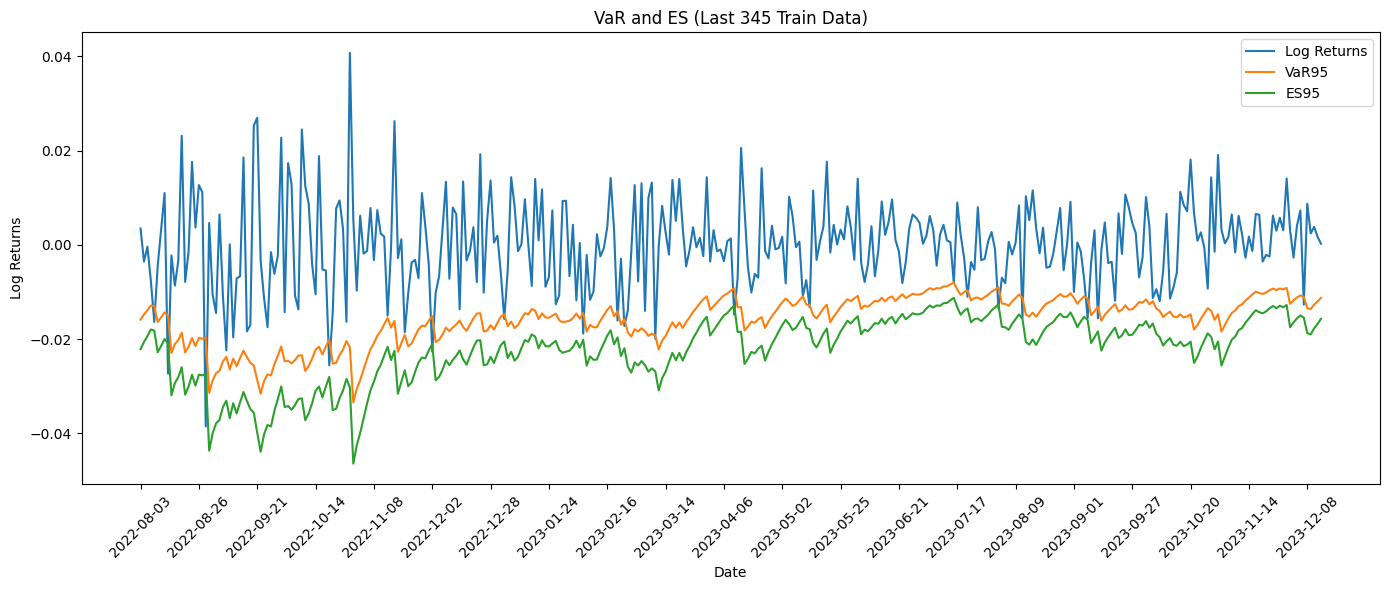

In [104]:
#garch_train_portfolio_VaR_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_portfolio_VaR.reshape(-1,1)).flatten())
#garch_train_portfolio_ES_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_portfolio_ES.reshape(-1,1)).flatten())
#
#plot_train_VaR_ES(portfolio_r_log, garch_train_portfolio_VaR_descaled, garch_train_portfolio_ES_descaled)

garch_train_VaR_skewt_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_VaR_skewt.reshape(-1,1)).flatten())
garch_train_ES_skewt_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_ES_skewt.reshape(-1,1)).flatten())

plot_train_VaR_ES(portfolio_r_log, garch_train_VaR_skewt_descaled, garch_train_ES_skewt_descaled)



---


# 4 - Model Evaluation and Backtesting

## Standard case on test dataset

In [105]:
# we have outputs already, create temporal matrix for the w to use the formula of variance of a portfolio
# columns of output are  ['cov', 'var_NVDA', 'var_SPY']
sigma_matrices = []
for pred in test_output:
    cov = pred[0]
    var_nvda = pred[1]
    var_spy = pred[2]
    sigma = np.array([[var_nvda, cov],
                      [cov, var_spy]])
    sigma_matrices.append(sigma)
print(sigma_matrices[1])

# now we create a temporal matrix, each day having w_0 of weights_nvda_pred_train and w_1 of weights_spy_pred_train
matrix_weights_pred = np.array([weights_nvda_pred, weights_spy_pred]).T
print("----------")
print(weights_nvda_pred[0])
print(matrix_weights_pred[0])

# now we create a matrix of the variance of the portfolio using the formula wT SIGMA w
variance_portfolio_pred = []
for i in range(len(matrix_weights_pred)):
    variance_portfolio_pred.append(np.dot(matrix_weights_pred[i].T, np.dot(sigma_matrices[i], matrix_weights_pred[i])))

[[4.98242555e-04 8.95435987e-05]
 [8.95435987e-05 5.71157403e-05]]
----------
-0.0852171168648709
[-0.08521712  1.08521712]


In [106]:
train_VaR_P, test_VaR_P, train_ES_P, test_ES_P = compute_VaR_ES(zero_mean, variance_portfolio_pred_train + variance_portfolio_pred, "Portfolio")

Train Portfolio mean VaR:
-0.014762737702756634
Test Portfolio mean VaR:
-0.016267827994787945
Train Portfolio mean ES:
-0.01835502342461167
Test Portfolio mean ES:
-0.02022635434727866


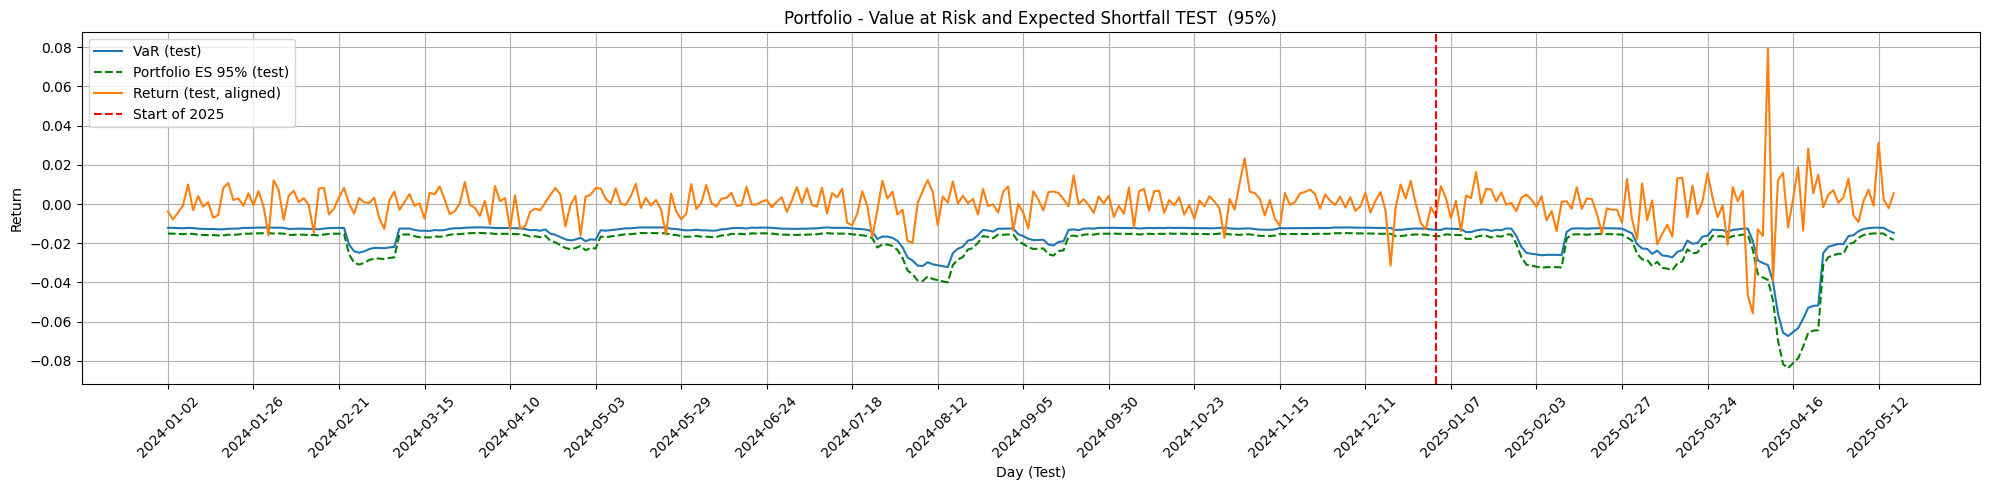

In [107]:
tail = test_length
date_range = dates[-tail:]

plt.figure(figsize=(20, 5))
plt.plot(test_VaR_P[:-1], label='VaR (test)')
plt.plot(test_ES_P[:-1], label='Portfolio ES 95% (test)', color='green', linestyle='--')
plt.plot(portfolio_returns_test[1:].reset_index(drop=True), label='Return (test, aligned)')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.title('Portfolio - Value at Risk and Expected Shortfall TEST  (95%)')
plt.xlabel('Day (Test)')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now we can backtest

In [108]:
compute_backtest_results(portfolio_returns_train, portfolio_returns_test, train_VaR_P, test_VaR_P)

Train VaR coverage: 0.052122
Test VaR coverage: 0.028986
Test VaR coverage (2024): 0.023810
Test VaR coverage (2025): 0.043011


## Stress case


### Arma

Train VaR coverage: 0.064084
Test VaR coverage: 0.072464
Test VaR coverage (2024): 0.063492
Test VaR coverage (2025): 0.096774


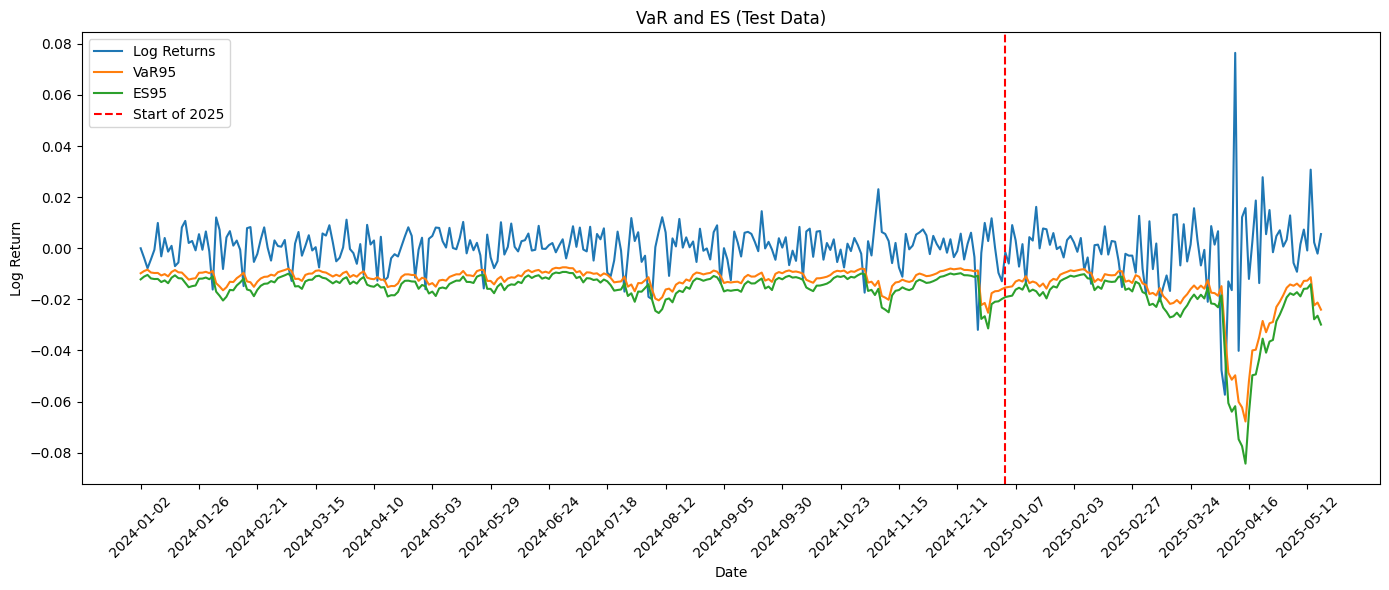

In [109]:
compute_backtest_results(portfolio_r_log, portfolio_test_r_log, arma_train_portfolio_VaR, arma_test_portfolio_VaR)
plot_test_VaR_ES(portfolio_test_r_log, arma_test_portfolio_VaR, arma_test_portfolio_ES)

### Garch

Train VaR coverage: 0.054970
Test VaR coverage: 0.046377
Test VaR coverage (2024): 0.035714
Test VaR coverage (2025): 0.075269


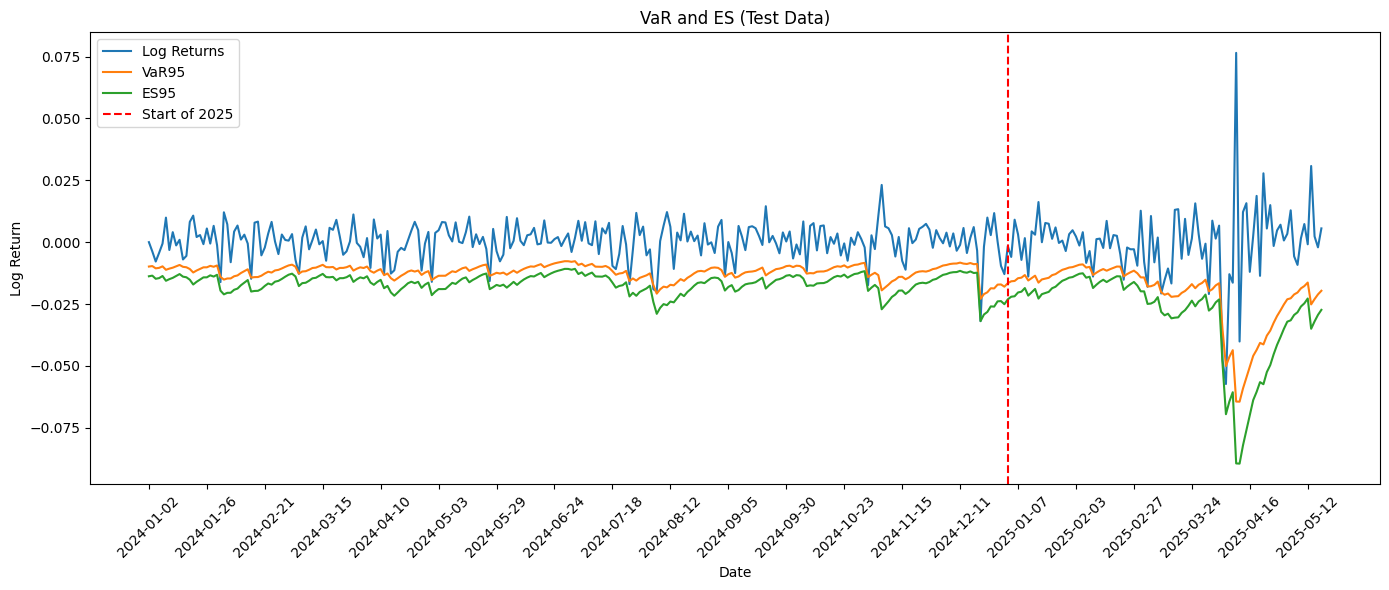

In [110]:
compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_VaR_skewt, garch_test_VaR_skewt)

# descale the values to have coerent graph
garch_test_portfolio_VaR_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_test_VaR_skewt.reshape(-1,1)).flatten())
garch_test_portfolio_ES_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_test_ES_skewt.reshape(-1,1)).flatten())

plot_test_VaR_ES(portfolio_test_r_log, garch_test_portfolio_VaR_descaled, garch_test_portfolio_ES_descaled)

## Asses performances

In [111]:
#from arch.univariate.distribution import SkewStudent
#
#def get_VaR_skewt(alpha, mean, std, eta, lam):
#    skewt_dist = SkewStudent()
#    q = skewt_dist.ppf(1 - alpha, [eta, lam])
#    VaR = mean + std * q
#    return VaR
#
#def get_ES_skewt(alpha, mean, std, eta, lam, n_points=40):
#    skewt_dist = SkewStudent()
#    # Average quantiles in the left tail up to VaR
#    levels = np.linspace(0.001, 1 - alpha, n_points)
#    q = skewt_dist.ppf(levels, [eta, lam])
#    mean_q = np.mean(q)
#    ES = mean + std * mean_q
#    return ES
#
#def compute_VaR_ES_skewt(mean, variance, eta, lam, asset):
#    variance = np.array(variance)
#    std = np.sqrt(variance)
#
#    train_VaR = get_VaR_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
#    test_VaR = get_VaR_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)
#
#    train_ES = get_ES_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
#    test_ES = get_ES_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)
#
#    print("Train", asset, "mean VaR (skewt):", np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
#    print("Test", asset, "mean VaR (skewt):", np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())
#    print("Train", asset, "mean ES (skewt):", np.asarray(train_ES)[~np.isnan(train_ES)].mean())
#    print("Test", asset, "mean ES (skewt):", np.asarray(test_ES)[~np.isnan(test_ES)].mean())
#
#    assert len(train_VaR) == train_length, "Train VaR length mismatch"
#    assert len(test_VaR) == test_length, "Test VaR length mismatch"
#    assert len(train_ES) == train_length, "Train ES length mismatch"
#    assert len(test_ES) == test_length, "Test ES length mismatch"
#
#    return train_VaR, test_VaR, train_ES, test_ES

In [112]:
#params = garch_portfolio.params
#eta = params['eta']      # degrees of freedom
#skew = params['lambda']  # skewness
#
#alpha = 0.95
#train_VaR_skewt, test_VaR_skewt, train_ES_skewt, test_ES_skewt = compute_VaR_ES_skewt(
#    garch_portfolio_mean, garch_portfolio_variance, eta, skew, "Portfolio"
#)
#
#compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, train_VaR_skewt, test_VaR_skewt)
#test_VaR_skewt = pd.Series(scaler_portfolio_r_log.inverse_transform(test_VaR_skewt.reshape(-1,1)).flatten())
#test_ES_skewt = pd.Series(scaler_portfolio_r_log.inverse_transform(test_ES_skewt.reshape(-1,1)).flatten())
#
#plot_test_VaR_ES(portfolio_test_r_log, test_VaR_skewt, test_ES_skewt)